In [1]:
import os
import sys
sys.path.insert(0, '../')

from pickle import load
import pandas as pd
import numpy  as np

from sklearn.metrics import r2_score

from src.utils import normalizer_inference_dataset, per_error, find_adj_score, evaluate_score_class_stratified
from src.config import models_features_per, model_name_conversion
from src.graph_visualization import visualization_testing_dataset, visualization_class_stratified

In [2]:
dataset_name      = '2023_12_17_LowConc5-gamma'  
dataset_path      = f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/old_dataset/{dataset_name}/feature_extraction_vwidth_0.15_root_min_testing.xlsx'
test_dataset      =  pd.read_excel(dataset_path)
normalizer_type   = 'mean_std'
add_alpha         = True
X_infer, y_infer  =  normalizer_inference_dataset(test_dataset, normalizer_type=normalizer_type)

In [3]:
root_model = '../models'
model_ver  = f"Data_augmentation_normalizer_type_{normalizer_type}_use_combat_False_outlier_remove_train_only_vwidth_0.15_root_min_{'_alpha' if add_alpha else ''}"

all_models = ['Linear', 'SVM', 'GP', 'RF', 'KNN']
y_LOD      = 0.9117010154341669

r2_score_val,  per_diff_val  = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}
r2_score_test, per_diff_test = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}

labels =sorted(y_infer.unique())

r2_score_class_stratified_test  = {'Models':[]} | {str(i):[] for i in labels}
per_diff_class_stratified_test  = {'Models':[]} | {str(i):[] for i in labels}

all_model_pred                  = {}

for model_name in all_models:
    with open(os.path.join(root_model, model_ver, f'{model_name}.pickle'), 'rb') as f: 
        model = load(f) 

    # models_features_per[model_name] = ['univariate, max(S)']
    
        
    y_pred        =  model.predict(X_infer[models_features_per[model_name]])
    r2_test_score =  r2_score(y_infer, y_pred)
    adj_r2_test   =  find_adj_score(len(y_pred), len(models_features_per[model_name]), r2_test_score)
    
    r2_score_test['Scores'].append((r2_test_score, adj_r2_test))
    per_diff_test['Scores'].append(per_error(y_infer, y_pred, y_LOD))

    r2_score_test['Models'].append(model_name)
    per_diff_test['Models'].append(model_name)

    # Add label stratified Results
    r2_score_class_stratified_test['Models'].append(model_name)
    per_diff_class_stratified_test['Models'].append(model_name)

    temp_output_r2       = evaluate_score_class_stratified(y_pred, y_infer)
    temp_output_per_diff = evaluate_score_class_stratified(y_pred, y_infer, score='per_diff', y_LOD=y_LOD)
    
    for label in y_infer.unique():
        r2_score_class_stratified_test[str(label)].append(temp_output_r2[label]['score'])
        per_diff_class_stratified_test[str(label)].append(temp_output_per_diff[label]['score'])

    all_model_pred[model_name] =  pd.DataFrame({'y_true':y_infer, 'y_pred':y_pred, 'diff': np.abs(y_infer - y_pred)})


In [4]:
savedir = os.path.join("../results/predicted_output", model_ver, dataset_name)
os.makedirs(savedir, exist_ok=True)

for model_name in all_model_pred:
    all_model_pred[model_name].to_excel(os.path.join(savedir, f'{model_name}.xlsx'))

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

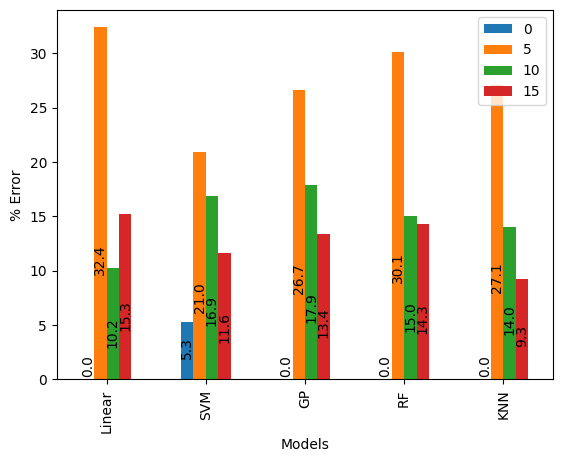

In [5]:

savedir      = os.path.join("../results/Inference Model", model_ver, dataset_name)
adj_score    = False

os.makedirs(savedir, exist_ok=True)

visualization_testing_dataset(r2_score_test,  f'{savedir}/r2_score_test.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_test, f'{savedir}/per_error_test.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_class_stratified(per_diff_class_stratified_test, f'{savedir}/per_error_class_stratified.png')

In [6]:
list(per_diff_class_stratified_test.keys())[1:]

['0', '5', '10', '15']

In [ ]:
all_data_5_